# imports de bibliotecas e de database

In [1]:
# !pip install nltk
# !pip install gensim
# !pip install scikit-learn
# !pip install pandas
# !pip install matplotlib
# !pip install wordcloud
# !pip install tensorflow
# !pip install transformers
# !pip install torch

In [2]:
import re 
import os 
import nltk
import gensim
import random
import numpy as np 
import unicodedata 
import pandas as pd 
import sklearn as skl
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from gensim.models import Word2Vec, KeyedVectors
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.regularizers import L2 # type: ignore
from tensorflow.keras.layers import Dropout # type: ignore
from tensorflow.keras.layers import Dense # type: ignore
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from tensorflow.keras import layers # type: ignore
from collections import defaultdict
from gensim.models import Word2Vec
from wordcloud import WordCloud
from zipfile import ZipFile 


# Download bases de dados e modelo word2vec de 100 dimensões já treinado

In [3]:
url = 'https://github.com/gazzola/corpus_readability_nlp_portuguese/archive/refs/heads/master.zip'
url2 = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'

# especifica o local onde ficarao os arquivos
pathFiles = 'dados/'
fileName = 'corpus_readability_nlp_portuguese.zip'

# cria uma pasta onde ficarao os arquivos
if not os.path.isdir(pathFiles):
    os.mkdir(pathFiles)

# faz o download do arquivo
os.system('wget -O %s%s %s' %(pathFiles, fileName, url))
fileName2 = 'cbow_s100.zip'
os.system('wget -O %s%s %s' %(pathFiles, fileName2, url2))

print('Arquivos extraídos com sucesso!')


Arquivos extraídos com sucesso!


In [4]:
# descompacta a base de dados de notícias
z = ZipFile('dados/corpus_readability_nlp_portuguese.zip', 'r')
z.extractall('dados/')
z.close()

z = ZipFile('dados/cbow_s100.zip', 'r')
z.extractall('dados/')
z.close()

# Importação dos datasets e target

é possivel ver que os datasets não estão balanceados

In [5]:
def import_Dataset(path):

    files = os.listdir(path)

    dataset = []

    for i, file in enumerate(files):

        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252

        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset

# importa as bases de dados
dataset_Fund1 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/1_Ensino_Fundamental_I')
print('Ensino Fundamental 1 importadas com sucesso, tamanho: %d' %len(dataset_Fund1))
dataset_Fund2 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/2_Ensino_Fundamental_II')
print('Ensino Fundamental 2 importadas com sucesso, tamanho: %d' %len(dataset_Fund2))
dataset_Medio = import_Dataset('dados/corpus_readability_nlp_portuguese-master/3_Ensino_Medio')
print('Ensino Medio importadas com sucesso, tamanho: %d' %len(dataset_Medio))
dataset_Superior = import_Dataset('dados/corpus_readability_nlp_portuguese-master/4_Ensino_Superior')
print('Ensino Superior importadas com sucesso, tamanho: %d' %len(dataset_Superior))

# concatena as bases de dados
dataset = np.asarray( dataset_Fund1+dataset_Fund2+dataset_Medio+dataset_Superior)

# cria um vetor para cada classe
target_Fund1 = np.zeros( len(dataset_Fund1), dtype=int )
target_Fund2 = np.ones( len(dataset_Fund2), dtype=int )
target_Medio = np.full(len(dataset_Medio), 2)
target_Superior = np.full(len(dataset_Superior), 3)

# concateca os vetores de classe
target = np.concatenate((target_Fund1, target_Fund2, target_Medio, target_Superior))

# obtem as classes do problema
classes = np.unique(target)

print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. textos target: %d' %len(target))

Ensino Fundamental 1 importadas com sucesso, tamanho: 297
Ensino Fundamental 2 importadas com sucesso, tamanho: 325
Ensino Medio importadas com sucesso, tamanho: 628
Ensino Superior importadas com sucesso, tamanho: 826

Qtd. textos dataset: 2076
Qtd. textos target: 2076


In [6]:
print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. Classes: %d' %len(pd.unique(classes)))
qtype = {}
for i in pd.unique(classes):
    print('Classe: %s, Qtd: %d, Porcentagem: %.2f' %(i, len(target[target==i]), len(target[target==i])/len(target)*100))
    qtype[i] = len(target[target==i])
    


Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 297, Porcentagem: 14.31
Classe: 1, Qtd: 325, Porcentagem: 15.66
Classe: 2, Qtd: 628, Porcentagem: 30.25
Classe: 3, Qtd: 826, Porcentagem: 39.79


# Balanceamento do Dataset
Como o dataset estava muito desbalanceado, com uma classe que representa mais de 74% e outra representando apenas 1.26%, então é necessário o balanceamento

In [7]:
#printar tipo do dataset
print(type(dataset))
#transformar em dataframe juntando com o target
df = pd.DataFrame({'text': dataset, 'target': target})

<class 'numpy.ndarray'>


In [8]:
print(qtype)
mean = np.array(list(qtype.values())).mean()
print(mean.round())

# Funcao para deletar linhas aleatoriamente
def delete_random_rows(df, type_value, num_to_delete):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) <= num_to_delete:
        return df.drop(index=indices)
    else:
        random_indices = random.sample(indices, num_to_delete)
        return df.drop(index=random_indices)

# Funcao para duplicar linhas aleatoriamente
def duplicate_random_rows(df, type_value, num_to_duplicate):
    indices = df[df['target'] == type_value].index.tolist()
    if len(indices) == 0:
        return df
    else:
        new_rows = df.loc[random.sample(indices, 1)]  # Sample existing row
        new_rows = pd.concat([new_rows] * num_to_create, ignore_index=True)
        return pd.concat([df, new_rows])

# Processa cada tipo de texto
for type_value in pd.unique(df['target']):
    count = qtype[type_value]
    if count > mean:
        num_to_delete = min(count - int(mean), count)
        df = delete_random_rows(df, type_value, num_to_delete)
    elif count < mean:
        num_to_create = int(mean) - count
        df = duplicate_random_rows(df, type_value, num_to_create)
        
print('\nAfter balancing:')
print('Qtd. textos dataset: %d' % len(df))
print('Qtd. Classes: %d' % len(pd.unique(df['target'])))
for i in pd.unique(df['target']):
    print('Classe: %s, Qtd: %d' % (i, len(df[df['target'] == i])))

print(df)

{0: 297, 1: 325, 2: 628, 3: 826}
519.0

After balancing:
Qtd. textos dataset: 2076
Qtd. Classes: 4
Classe: 0, Qtd: 519
Classe: 1, Qtd: 519
Classe: 2, Qtd: 519
Classe: 3, Qtd: 519
                                                  text  target
0     O jovem inventor Nicephóre Niepce foi quem co...       0
1     As coisas pioraram nas cidades, porque os pré...       0
2     Você acredita que mais de 600 mil lusitanos v...       0
3     Depois de dar um duro danado, acordando muito...       0
4     Para que todas essas coisas existam, as pesso...       0
..                                                 ...     ...
189  Sociologia. O gigantesco trabalho teórico do a...       1
190  Sociologia. O gigantesco trabalho teórico do a...       1
191  Sociologia. O gigantesco trabalho teórico do a...       1
192  Sociologia. O gigantesco trabalho teórico do a...       1
193  Sociologia. O gigantesco trabalho teórico do a...       1

[2076 rows x 2 columns]


# Preprocessing

In [9]:
# Download stopwords corpus
nltk.download('stopwords')

# Download RSLPStemmer
nltk.download('rslp')

from nltk.stem import RSLPStemmer # para fazer a estemização em documentos da lingua portuguesa

def preprocessing_portuguese(text, stemming = False, stopwords = False):

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=False, stopwords=False):
        self.stemming = stemming
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [preprocessing_portuguese(x, self.stemming, self.stopwords) for x in X]
    

<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\mathe\AppData\Local\Temp\ipykernel_24384\1791963403.py:23: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('(http|https)://[^\s]*')
C:\Users\mathe\AppData\Local\Temp\ipykernel_24384\1791963403.py:27: SyntaxWarning: invalid escape sequence '\s'
  regex = re.compile('[^\s]+@[^\s]+')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# funções para o embedding


In [10]:
class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, pretreinado, vector_size, window, min_count, maxLength = 100):
        self.pretreinado = pretreinado
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        self.maxLength = maxLength

    def fit(self, X, y=None):
        
        if self.pretreinado:
            self.model = KeyedVectors.load_word2vec_format('dados/cbow_s100.txt')
        else:
            self.model = Word2Vec(sentences = X,
                          vector_size = self.vector_size,
                          window = self.window,
                          min_count = self.min_count)
        return self


    def transform(self, X, y=None):
        if self.pretreinado:
            return self.dataset2featureMatrix2(X, self.model)
        else:
            return self.dataset2featureMatrix(X, self.model)
    
    def getDocvector(self, model, doc, maxLength = 100):

        embedding_dim = model.wv[model.wv.index_to_key[0]].shape[0]

        
        wordVecs = []

        for i in range(maxLength):

            wordVecs.append( np.zeros(embedding_dim) )

            if i<len(doc):

                try:
                    wordVecs[i] = model.wv[ doc[i] ]
                except:
                    pass 


        wordVecs = np.array(wordVecs)
        return wordVecs

    def dataset2featureMatrix(self, dataset, embeddingModel):

        X_embedding = []
        for doc in dataset:
            vec = self.getDocvector(embeddingModel, doc)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)

        return X_embedding
    

    def getDocvector2(self, model, doc, maxLength = 100):
        
        embedding_dim = model[model.index_to_key[0]].shape[0]

        wordVecs = []

        for i in range(maxLength):

            wordVecs.append( np.zeros(embedding_dim) )

            if i<len(doc):

                try:
                    wordVecs[i] = model[ doc[i] ]
                except:
                    pass 

        wordVecs = np.array(wordVecs)

        return wordVecs

    def dataset2featureMatrix2(self, dataset, embeddingModel):

        word2v = []
        for doc in dataset:
            vec = self.getDocvector2(embeddingModel, doc)
            word2v.append(vec)

        word2v = np.array(word2v)

        return word2v

# nuvem de palavra do dataset

é  possivel observar que precisa do preprocessamento

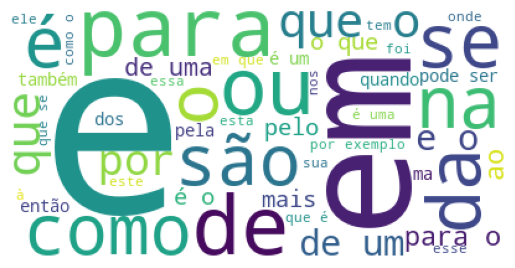

In [11]:
wc = WordCloud(min_font_size = 10, max_font_size = 200, 
               background_color = "white", relative_scaling=0.5)

# Adicione o texto à nuvem de palavras
wc.generate(" ".join(dataset))

# Plote a nuvem de palavras
plt.imshow(wc)
plt.axis("off")
plt.show()

# Divisão do dataset 


In [12]:
dataset = df['text']
target = df['target']

display(dataset.head())
display(target.head())

0     O jovem inventor Nicephóre Niepce foi quem co...
1     As coisas pioraram nas cidades, porque os pré...
2     Você acredita que mais de 600 mil lusitanos v...
3     Depois de dar um duro danado, acordando muito...
4     Para que todas essas coisas existam, as pesso...
Name: text, dtype: object

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset,  # Dados com os títulos e textos
    target,   # Classes correspondentes
    test_size=0.2,  # Porcentagem dos dados a serem usados como conjunto de teste
    random_state=42  # Semente para a geração de números aleatórios para reprodutibilidade
)
# display(X_train.head())
# display(y_train.head())
# display(X_test.head())
# display(y_test.head())
print(X_train.shape)
print(X_test.shape)
print('\nQtd. textos dataset: %d' %len(dataset))
print('\nQtd. textos dataset: %d' %len(X_train))
print('\nQtd. textos dataset: %d' %len(X_test))

(1660,)
(416,)

Qtd. textos dataset: 2076

Qtd. textos dataset: 1660

Qtd. textos dataset: 416


# definição dos pipeline e execução do Grid Search

In [14]:

class GRU(BaseEstimator, TransformerMixin):
    def __init__(self, maxlength = 100, units = 100, optimizer = 'adam', output_layer_size = 4, dropout = 0, epochs = 5, learning_rate = 0.001 ):
        self.model = None
        self.output_layer_size = output_layer_size
        self.optimizer = optimizer
        self.units = units
        self.dropout = dropout
        self.epochs = epochs
        self.maxlength = maxlength
        self.learning_rate = learning_rate
        # # Configura o modelo de rede neural artificial
        self.model = tf.keras.Sequential()

    def fit(self, X, y):
        self.model.add(layers.GRU(units=self.units, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
        
        self.model.add(layers.BatchNormalization())

        if (self.dropout > 0):
            self.model.add(Dropout(self.dropout))


        reg = tf.keras.regularizers.l2(0.1) # regularizacao
        self.model.add(layers.GRU(units=self.units, return_sequences=False, input_shape=(X.shape[1], X.shape[2]), kernel_regularizer = reg))
        self.model.add(layers.BatchNormalization())
        if (self.dropout > 0):
            self.model.add(Dropout(self.dropout))


        self.model.add(layers.Dense(units=4, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      
        self.history = self.model.fit(X, y, epochs = self.epochs, batch_size=100, validation_split=0.2, verbose = 0)


        return self.history
    

    def transform(self, X, y=None):
        return self


    def predict(self, X_test):
        y_pred = self.model.predict(X_test)
        return y_pred
    
    def clean(self):
        self.model = Sequential()

    def get_history(self):
        return self.history


## Com todos os parametros


Método:  GRU Word2Vec
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  20
learning_rate:  0.001
units:  10
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.43990384615384615 macro_f1 0.4016790371360023 precision 0.5959368803275733 recall 0.44536052518295305 auc 0.6788476347930199
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  20
learning_rate:  0.01
units:  20
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.5456730769230769 macro_f1 0.5377405106970324 precision 0.7358152173913043 recall 0.5451323719328455 auc 0.8514415281823534
Parâmetros: 
stemming:  False
stopwords:  False
epochs:  10
learning_rate:  0.001
units:  20
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.4423076923076923 macro_f1 0.41438044976103183 precision 0.6981606818563341 recall 0.448438441670254 auc 0.7051767146866808
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  10
learning_rate:  0.001
units:  10
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.3317307692307692 macro_f1 0.22468218056453348 precision 0.2929430894308943 recall 0.33043478260869563 auc 0.6941982100150004
Parâmetros: 
stemming:  True
stopwords:  False
epochs:  20
learning_rate:  0.1
units:  30
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
accuracy 0.5649038461538461 macro_f1 0.545426620555869 precision 0.7238500736262884 recall 0.5600882479552304 auc 0.818490936041955
Parâmetros: 
stemming:  True
stopwords:  False
epochs:  10
learning_rate:  0.01
units:  30
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.31971153846153844 macro_f1 0.20836777308913734 precision 0.15501387925052046 recall 0.3325 auc 0.7186641913237226
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  10
learning_rate:  0.001
units:  30
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.39903846153846156 macro_f1 0.3652309616249987 precision 0.41432974544060813 recall 0.4131435643564356 auc 0.7158221140063874
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  30
learning_rate:  0.001
units:  20
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.32211538461538464 macro_f1 0.28523475445223956 precision 0.37577178744749395 recall 0.3225269048643995 auc 0.6841545990943205
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  30
learning_rate:  0.01
units:  30
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.6418269230769231 macro_f1 0.6411489512993273 precision 0.6868823806790224 recall 0.6484395178648299 auc 0.8500227870810066
Parâmetros: 
stemming:  False
stopwords:  False
epochs:  20
learning_rate:  0.1
units:  20
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.4206730769230769 macro_f1 0.3625181432704576 precision 0.36038178741143734 recall 0.408804347826087 auc 0.737945178547047
Melhor Acurácia:  0.5456730769230769
Melhor Macro F1:  0.5377405106970324
Melhor precisão:  0.7358152173913043
Melhor revocação:  0.5451323719328455
Melhor AUC:  0.8514415281823534
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': False, 'clf__units': 20, 'clf__maxlength': 100, 'clf__learning_rate': 0.01, 'clf__epochs': 20, 'clf__dropout': 0}


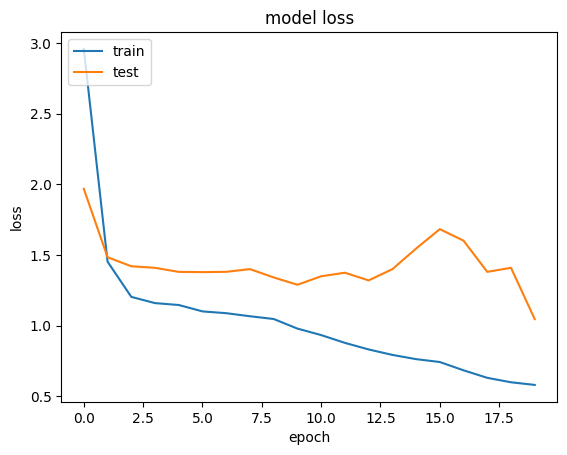


Método:  GRU Word2Vec pretreinado
Parâmetros: 
stemming:  True
stopwords:  False
epochs:  10
learning_rate:  0.01
units:  10
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.35336538461538464 macro_f1 0.2690460154620016 precision 0.5677506775067751 recall 0.36747524752475247 auc 0.6915593096607024
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  30
learning_rate:  0.1
units:  20
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.5408653846153846 macro_f1 0.5248286493724006 precision 0.5776707094121903 recall 0.5305359448988378 auc 0.8246321913839582
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  10
learning_rate:  0.001
units:  20
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.4423076923076923 macro_f1 0.425605131734759 precision 0.6655844155844156 recall 0.44658631080499356 auc 0.7009533960314243
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  20
learning_rate:  0.001
units:  30
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.4519230769230769 macro_f1 0.4750279387536436 precision 0.662431941923775 recall 0.45727507533362033 auc 0.7244032595621818
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  20
learning_rate:  0.1
units:  20
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.43990384615384615 macro_f1 0.38983572316905646 precision 0.444584822712519 recall 0.43699418854928973 auc 0.7420289102158418
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  10
learning_rate:  0.1
units:  20
dropout:  0
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.2403846153846154 macro_f1 0.09689922480620156 precision 0.06009615384615385 recall 0.25 auc 0.6640015941360019
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  30
learning_rate:  0.001
units:  10
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.4519230769230769 macro_f1 0.43236764126600546 precision 0.6558209404826078 recall 0.45495587602238485 auc 0.7043245655700482
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  30
learning_rate:  0.001
units:  20
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.4519230769230769 macro_f1 0.4586024944035817 precision 0.6041526793868635 recall 0.45666379681446406 auc 0.7156819042206721
Parâmetros: 
stemming:  False
stopwords:  True
epochs:  20
learning_rate:  0.1
units:  10
dropout:  0.1
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
accuracy 0.5360576923076923 macro_f1 0.5359563098709642 precision 0.8353242320819113 recall 0.5390206629358588 auc 0.7614946041501234
Parâmetros: 
stemming:  True
stopwords:  True
epochs:  20
learning_rate:  0.1
units:  30
dropout:  0.01
maxlength:  100


d:\Estudo\Projetos\IA\Estudo-Classificacao-de-textos\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
accuracy 0.40865384615384615 macro_f1 0.3744761083251183 precision 0.6573699180190731 recall 0.40387107188979765 auc 0.7465787410283453
Melhor Acurácia:  0.5408653846153846
Melhor Macro F1:  0.5248286493724006
Melhor precisão:  0.5776707094121903
Melhor revocação:  0.5305359448988378
Melhor AUC:  0.8246321913839582
Melhores Parâmetros:  {'preprocessing__stopwords': True, 'preprocessing__stemming': True, 'clf__units': 20, 'clf__maxlength': 100, 'clf__learning_rate': 0.1, 'clf__epochs': 30, 'clf__dropout': 0.01}


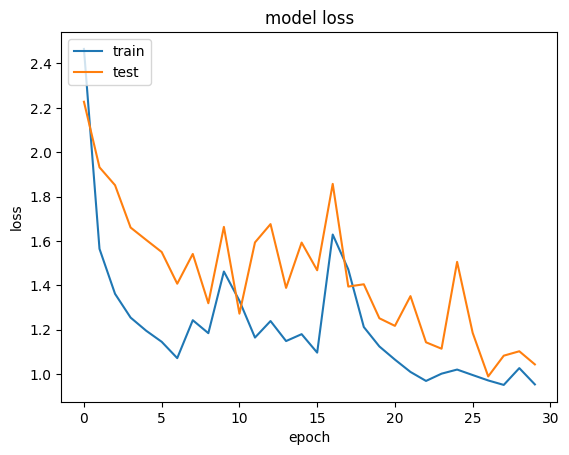

In [16]:

maxlength = 100
pipelines = [
    
    ('GRU Word2Vec', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado='False', vector_size=maxlength, window=3,min_count=1)),
        ('clf', GRU()),
    ])),
    ('GRU Word2Vec pretreinado', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado='True', vector_size=maxlength, window=3,min_count=1)),
        ('clf', GRU()),
    ])),
]

# Definindo a grade de parâmetros
parameters = {
    'preprocessing__stemming': [False, True],
    'preprocessing__stopwords': [False, True],
    'clf__epochs':[10, 20, 30],
    'clf__learning_rate':[0.001, 0.01, 0.1],
    'clf__units':[10,20,30],
    'clf__dropout':[0, 0.1, 0.01],
    'clf__maxlength': [maxlength]
}

param_distributions = ParameterSampler(parameters, n_iter=10)

best_auc_pipeline = 0
best_pipeline = None
preprocessed_X_train = None
for name, pipeline in pipelines:
    best_accuracy = 0
    best_auc = 0
    best_params = None
    best_history = None
    print("\nMétodo: ", name)

    for params in param_distributions:
        print("Parâmetros: ")
        print("stemming: ", params['preprocessing__stemming'])
        print("stopwords: ", params['preprocessing__stopwords'])
        print("epochs: ", params['clf__epochs'])
        print("learning_rate: ", params['clf__learning_rate'])
        print("units: ", params['clf__units'])
        print("dropout: ", params['clf__dropout'])
        print("maxlength: ", params['clf__maxlength'])

# Verifica se os dados pré-processados já existem no dicionário
        
        pipeline.set_params(**params)
        # Ajusta o pipeline aos dados pré-processados
        pipeline.fit(X_train, y_train)
        history = pipeline.named_steps['clf'].get_history()
        Y_pred = pipeline.predict(X_test )
        y_pred = np.argmax(Y_pred, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1 = f1_score(y_test, y_pred, average='macro'  )
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro')
        auc = roc_auc_score(y_test, Y_pred, average='macro', multi_class='ovr')
        pipeline.named_steps['clf'].clean()
        tf.keras.backend.clear_session()
        # display('accuracy', accuracy, 'macro_f1', macro_f1, 'precision', precision, 'recall', recall, 'auc', auc)
        print('accuracy', accuracy, 'macro_f1', macro_f1, 'precision', precision, 'recall', recall, 'auc', auc)
        # Se o auc for melhor que o melhor auc até agora, atualiza o melhor auc e os melhores parâmetros
        if auc > best_auc:
            best_accuracy = accuracy
            best_macro = macro_f1
            best_precision = precision
            best_recall = recall
            best_params = params
            best_pipeline = pipeline
            best_history = history
            best_auc = auc

    
    if best_auc > best_auc_pipeline:
        best_auc_pipeline = best_auc
        best_pipeline = pipeline
    print("Melhor Acurácia: ", best_accuracy)
    print("Melhor Macro F1: ", best_macro)
    print("Melhor precisão: ", best_precision)
    print("Melhor revocação: ", best_recall)
    print("Melhor AUC: ", best_auc)
    print("Melhores Parâmetros: ", best_params)

    plt.plot(best_history.history['loss'])
    plt.plot(best_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
